In [ ]:
# Installing packages

!pip install wordninja==2.0.0 numpy==1.22.4 contractions==0.1.73 nltk==3.8.1 tensorflow==2.12.0 tensorflow-text==2.12.1 tensorflow-hub==0.13.0 matplotlib==3.7.1 seaborn==0.12.2 scikit-learn==1.2.2 plotly==5.13.1 PyMuPDF==1.22.1 bert-for-tf2==0.14.9 requests==2.27.1 pandas==1.5.3 wordcloud==1.8.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing librabries

import requests
import os
import fitz
import glob
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.corpus import words
import wordninja
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
from plotly.offline import iplot
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score,
                             precision_score, recall_score, f1_score,
                             cohen_kappa_score, matthews_corrcoef, classification_report)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [ ]:
# List of download links and corresponding file names
download_links = [
    {'url': 'https://drive.google.com/uc?export=download&id=1-_WoifNaLCaxcEwyTl865589E3m4qAxS', 'filename': 'Biology1.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1wmfh8CkrMWjyOvNkXrsymmw3PmFomOUB', 'filename': 'Biology2.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=16u0trx49fQvYGYmz6N7egNAaWE6zxFAQ', 'filename': 'Computer_Science1.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1S6DkHjHUzNzmVHdp4bgz7Lpxb16ZXEy2', 'filename': 'Computer_Science2.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1Va109nfuG2U68qeH2FlNJ3uZOXAqjnpO', 'filename': 'Computer_Science3.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=19CKD4K1uyngyafUI8_uFaiD0w71F4COx', 'filename': 'Computer_Science4.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1zarC3y6BdQqY3j7mjRPBletmkVg6yBHh', 'filename': 'Computer_Science5.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1dsunh17Z72hxjffVhum36AhnKCIjt4ys', 'filename': 'History1.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1t92NXqBp4htdCdO14DKzrnzdAklIxFPp', 'filename': 'History2.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1K-CIzcw4rhapwA7v4MbJtX755PwJva_b', 'filename': 'History3.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1XUCBVhbCAYasVLjtZGVM0OQGuHNUlDTJ', 'filename': 'History4.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1q7iAHeIhAxNXA3O__SwZJ8IruzOSoOyf', 'filename': 'History5.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1EeITsFsc5g40mBg3EwT9F8DeG5KKnEML', 'filename': 'History6.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1mU25GRO0SrTFPy44PPquXmMEOrPRGbic', 'filename': 'Physics1.pdf'},
    {'url': 'https://drive.google.com/uc?export=download&id=1nqtPR81L9BExsu4lBTS7J_sHiErAyygb', 'filename': 'Physics2.pdf'}
]

# Loop through the download links and download each file
for item in download_links:
    url = item['url']
    filename = item['filename']

    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

        print(f"Downloaded {filename}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")


Downloaded Biology1.pdf
Downloaded Biology2.pdf
Downloaded Computer_Science1.pdf
Downloaded Computer_Science2.pdf
Downloaded Computer_Science3.pdf
Downloaded Computer_Science4.pdf
Downloaded Computer_Science5.pdf
Downloaded History1.pdf
Downloaded History2.pdf
Downloaded History3.pdf
Downloaded History4.pdf
Downloaded History5.pdf
Downloaded History6.pdf
Downloaded Physics1.pdf
Downloaded Physics2.pdf


In [ ]:
# Extracting the text from the pdf file

def split_text(text):
    words = text.split()
    half = len(words) // 2
    return ' '.join(words[:half]), ' '.join(words[half:])

def is_empty_file(file_path):
    return os.path.getsize(file_path) == 0

def remove_empty_file(file_path):
    if is_empty_file(file_path):
        os.remove(file_path)

def extract_text(pdf_file, subject_dir):
    os.makedirs(subject_dir, exist_ok=True)
    merged_text = ""

    try:
        with fitz.open(pdf_file) as pdf:
            for i, page in enumerate(pdf):
                text = page.get_text()
                words = text.split()
                if len(words) < 100:
                    merged_text += " " + text
                    continue

                if merged_text:
                    half1, half2 = split_text(merged_text)
                    file1_path = os.path.join(subject_dir, f'{os.path.splitext(os.path.basename(pdf_file))[0]}_merged_part1.txt')
                    with open(file1_path, 'w') as f1:
                        f1.write(half1)
                    remove_empty_file(file1_path)

                    file2_path = os.path.join(subject_dir, f'{os.path.splitext(os.path.basename(pdf_file))[0]}_merged_part2.txt')
                    with open(file2_path, 'w') as f2:
                        f2.write(half2)
                    remove_empty_file(file2_path)
                    merged_text = ""

                half1, half2 = split_text(text)

                file1_path = os.path.join(subject_dir, f'{os.path.splitext(os.path.basename(pdf_file))[0]}_page_{i+1}_part1.txt')
                with open(file1_path, 'w') as f1:
                    f1.write(half1)
                remove_empty_file(file1_path)

                file2_path = os.path.join(subject_dir, f'{os.path.splitext(os.path.basename(pdf_file))[0]}_page_{i+1}_part2.txt')
                with open(file2_path, 'w') as f2:
                    f2.write(half2)
                remove_empty_file(file2_path)
    except Exception as e:
        print(f"Error processing {pdf_file}: {e}")

if __name__ == '__main__':
    base_dir = "Dataset"
    subject_files = {
        'Computer_Science': [
            './Computer_Science1.pdf',
            './Computer_Science2.pdf',
            './Computer_Science3.pdf',
            './Computer_Science4.pdf',
            './Computer_Science5.pdf',
        ],
        'Physics': [
            './Physics1.pdf',
            './Physics2.pdf'
        ],
        'Biology': [
            './Biology1.pdf',
            './Biology2.pdf'
        ],
        'History': [
            './History1.pdf',
            './History2.pdf',
            './History3.pdf',
            './History4.pdf',
            './History5.pdf',
            './History6.pdf'
        ]
    }

    for subject, pdf_files in subject_files.items():
        print(f"Extracting text for {subject}")
        subject_dir = os.path.join(base_dir, subject)
        for pdf_file in pdf_files:
            extract_text(pdf_file, subject_dir)

Extracting text for Computer_Science
Extracting text for Physics
Extracting text for Biology
Extracting text for History


In [ ]:
# Reads the extracted text data from multiple text files located in subfolders of a specified directory and appends the text data to data list and corresponding categories to category list.

data = []
category = []

# Set the path to the folder containing subfolders
path = os.path.expanduser("./Dataset")

# Loop over the subfolders and their contents
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        for file_path in glob.glob(os.path.join(folder_path, "*.txt")):
            # Read the text data from the file
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()
            # Append the text and category to the data and labels lists
            data.append(text)
            category.append(folder)



In [ ]:
# Get the number of datapoints in the dataset
num_datapoints = len(data)

# Print the number of datapoints
print('Number of datapoints:', num_datapoints)

Number of datapoints: 13110


In [ ]:
# Print first hundred data list

data[:100]

['90 2. Is it acceptable for an individual to ignore the possibility of truncation errors and their consequences when developing his or her own applications? 3. Was it ethical to develop software in the 1970s using only two digits to repre- sent the year (such as using 76 to represent the year 1976), ignoring the fact that the software would be flawed as the turn of the century approached? Is it ethical today to use only three digits to represent the year (such as 982 for 1982 and 015 for 2015)? What about using only four digits? 4. Many argue that encoding information often dilutes or otherwise distorts the information, since it essentially forces the information to be quantified. They argue that a questionnaire in which subjects are required to record their opinions by responding within a scale from one to five is inherently flawed. To what extent is information quantifiable? Can the pros and cons of different locations for a waste disposal plant be quantified? Is the debate over nuc

In [ ]:
# Print first two categories

category[:2]

['Computer_Science', 'Computer_Science']

In [ ]:
# download punkt and stopwords dataset from nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# download words dataset from nltk
nltk.download('words')

# Load the set of English words
english_words = set(words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# Define a function to preprocess the data

def preprocess_text(text):

    # Remove newlines
    text = re.sub(r'\n+', ' ', text)

    # Remove hyphens and put spaces
    text = re.sub(r'-', ' ', text)

    # Remove words containing numbers
    text = re.sub(r'\b\w*\d\w*\b', ' ', text)

    # Replace one or two letter words with an empty string
    text = re.sub(r'\b\w{1,2}\b', '', text)

    # Remove Roman numerals
    text = re.sub(r'\b[IVXLCDM]+\b', ' ', text, flags=re.IGNORECASE)

    # Convert to lowercase
    text = text.lower()

    # Separate joined words
    text = ' '.join(wordninja.split(text))

    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)

    # Remove any special characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Replace duplicate word with single word
    text = re.sub(r'\b(\w+)\s+\1\b', r'\1', text, flags=re.IGNORECASE)

    # Remove punctuation
    text = re.sub(r'[^\w\s]|_', ' ', text)

    # Remove specific words
    text = re.sub(r'\b(?:one|two|use|also|would|first|fig|may|used|see|new|differennt|called|many|find|part|number|using|work|chapter|example|must|true|cos|false|within|result|much|another|figure|form|three|like|however|given)\b', " ", text, flags=re.IGNORECASE)
    text = re.sub(r'\b(?:oh|ost|coo|coa|syn|yl|lih|gre|sni|tait|al|ce|ten|elo|oid|ley|rer|se|isra|blu|lk|lu|ree|lt|lus|lu|el|line|thus|end|process|change|different|could)\b', '', text, flags=re.IGNORECASE)

    # Remove single alphabets excluding "a"
    text = re.sub(r"(?<![a-zA-Z])[^aA\s][^a-zA-Z]?(?![a-zA-Z])", "", text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
# Apply the function

preprocessed_data = [preprocess_text(text) for text in data]

In [ ]:
# View the data before preprocessing

data[12100:12200]

['Nerve Tissue The fourth major class of vertebrate tissue is nerve tissue (table 49.5). Its cells include neurons and neuroglia, or sup- porting cells. Neurons are specialized to produce and con- duct electrochemical events, or “impulses.” Each neuron consists of three parts: cell body, dendrites, and axon (fig- ure 49.12). The cell body of a neuron contains the nucleus. Dendrites are thin, highly branched extensions that receive incoming stimulation and conduct electric events to the cell body. As a result of this stimulation and the electric events produced in the cell body, outgoing impulses may be pro- duced at the origin of the axon. The axon is a single exten- sion of cytoplasm that conducts impulses away from the cell body. Some axons can be quite long. The cell bodies of neurons that control the muscles in your feet, for example, lie in the spinal cord, and their axons may extend over a meter to your feet. Neuroglia do not conduct electrical impulses but instead support and in

In [ ]:
# View the data after preprocessing

preprocessed_data[12100:12200]

['nerve tissue the fourth major class vertebrate tissue nerve tissue table its cells include neurons and neuro glia sup porting cells neurons are specialized produce and con duct electrochemical events impulses each neuron consists parts cell body dendrites and axon ure the cell body neuron contains the nucleus dendrites are thin highly branched extensions that receive incoming stimulation and conduct electric events the cell body this stimulation and the electric events produced the cell body outgoing impulses pro duce the origin the axon the axon single ex sion cytoplasm that conducts impulses away from the cell body some axons can quite long the cell bodies neurons that control the muscles your feet for lie the spinal cord and their axons extend over meter your feet neuro glia not conduct electrical impulses but instead support and insulate neurons and eliminate foreign mater als and around neurons neurons neuro glia cells associate with the axons and insulating covering myelin shea

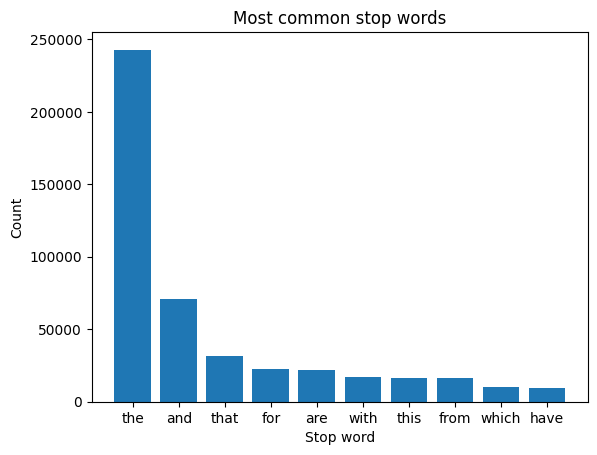

In [ ]:
# Get the list of stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

# Count the occurrences of each stop word in the datasets
stop_word_counts = Counter([word for dataset in preprocessed_data for word in dataset.split() if word in stop_words])

# Get the 10 most common stop words
most_common_stop_words = stop_word_counts.most_common(10)

# Plot the graph
plt.bar([word[0] for word in most_common_stop_words], [word[1] for word in most_common_stop_words])
plt.title('Most common stop words')
plt.xlabel('Stop word')
plt.ylabel('Count')
plt.show()


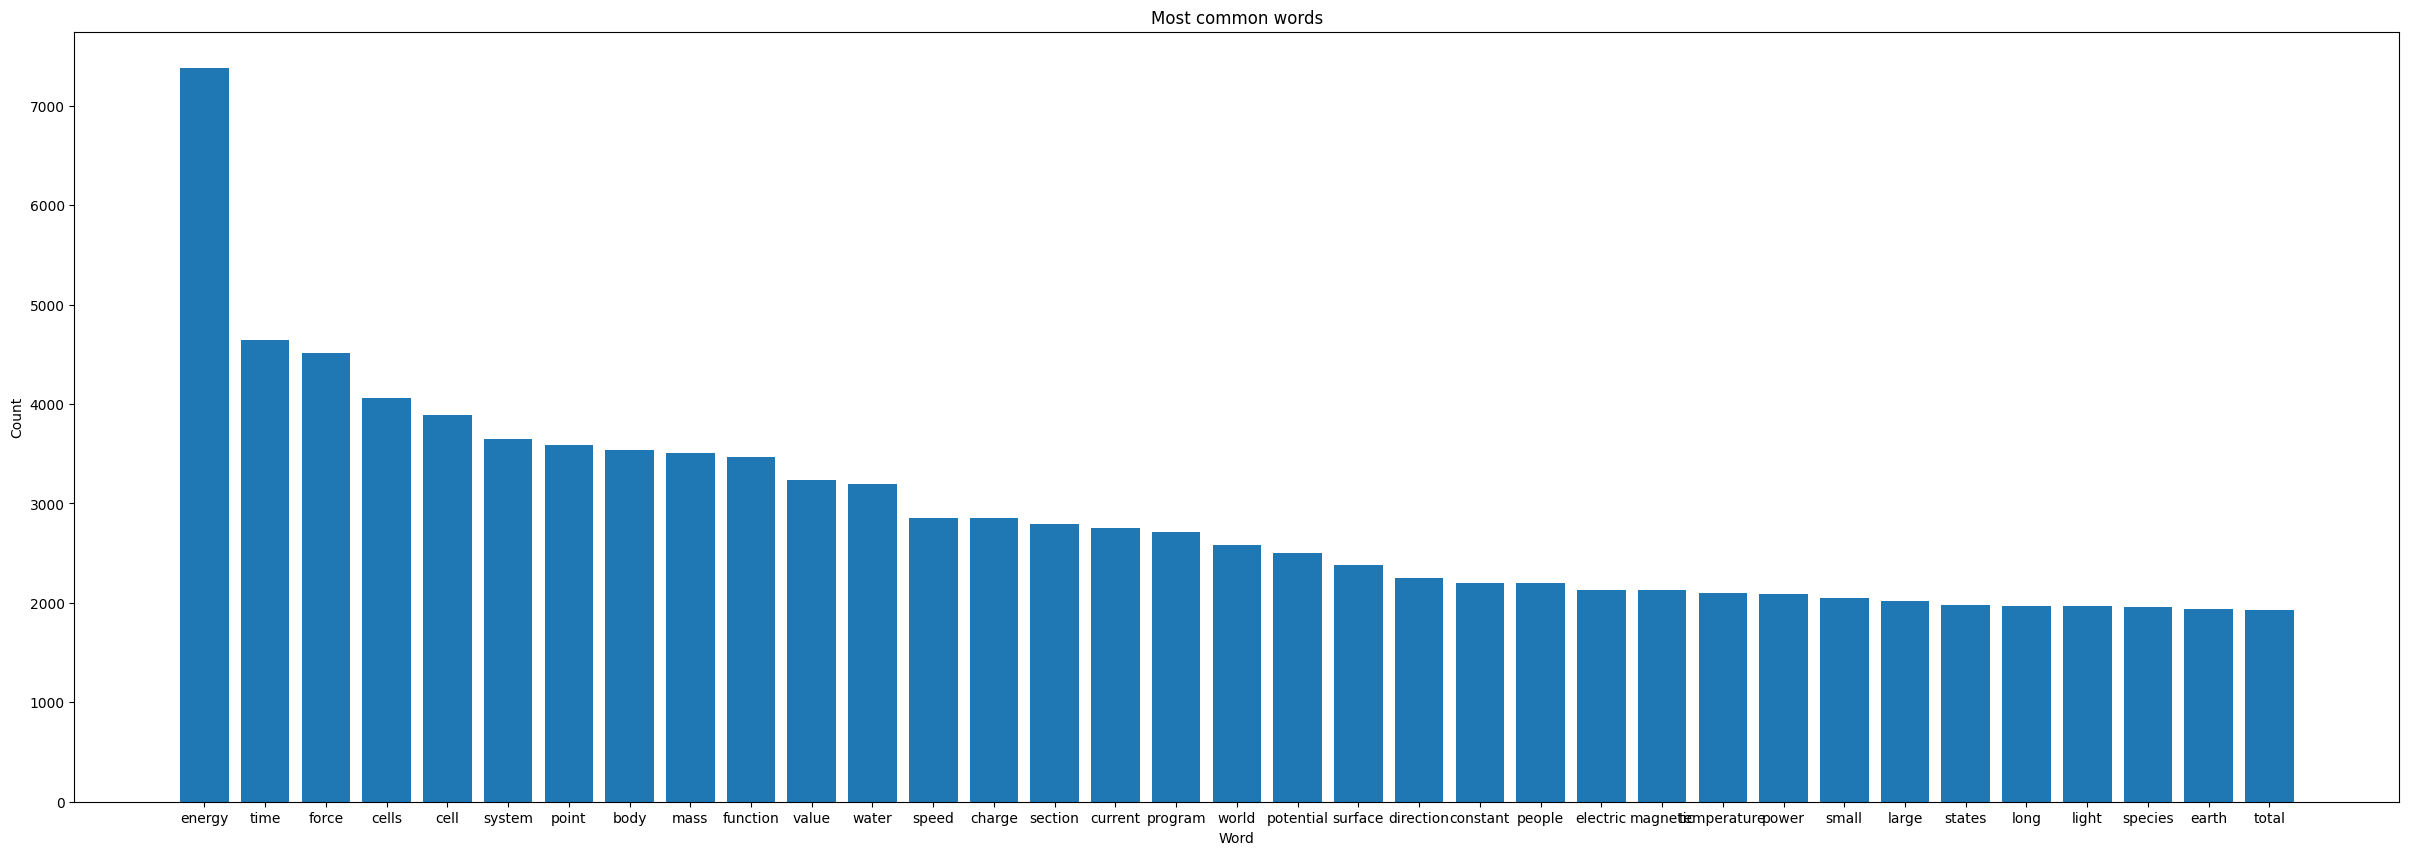

In [ ]:
# Count the occurrences of each stop word in the datasets
word_counts = Counter([word for text in preprocessed_data for word in text.split() if word not in stop_words])

# Get the 35 most common words
most_common_words = word_counts.most_common(35)

# Set the figure size
plt.figure(figsize=(30, 10))

# Plot the graph
plt.bar([word[0] for word in most_common_words], [word[1] for word in most_common_words])
plt.title('Most common words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [ ]:
# Create a DataFrame with the preprocessed data and corresponding category
df = pd.DataFrame({'preprocessed_data': preprocessed_data, 'Category': category})

# Filter your data based on each label
data_biology = df[df['Category'] == 'Biology']['preprocessed_data']
data_computer_science = df[df['Category'] == 'Computer_Science']['preprocessed_data']
data_history = df[df['Category'] == 'History']['preprocessed_data']
data_physics = df[df['Category'] == 'Physics']['preprocessed_data']

In [ ]:
# Define a function to create wordcloud
def create_word_cloud(data, label):
    # Join the different processed texts together
    long_string = ','.join(data)

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="black", max_words=1000, contour_width=3, contour_color='steelblue')

    # Generate a word cloud
    wordcloud.generate(long_string)

    # Visualize the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {label}")
    plt.show()


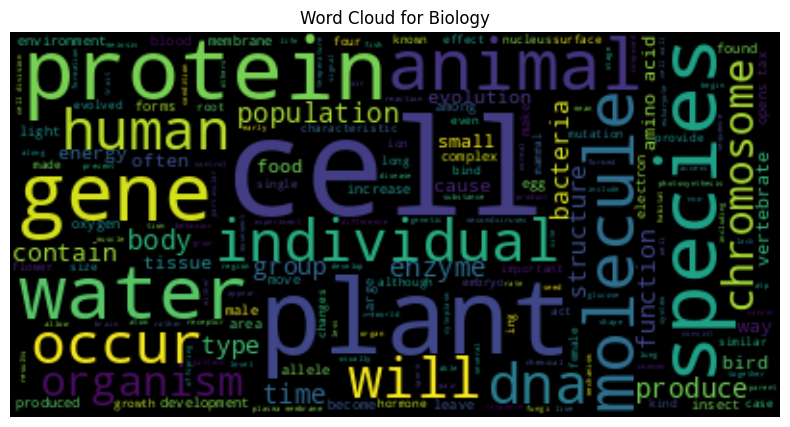

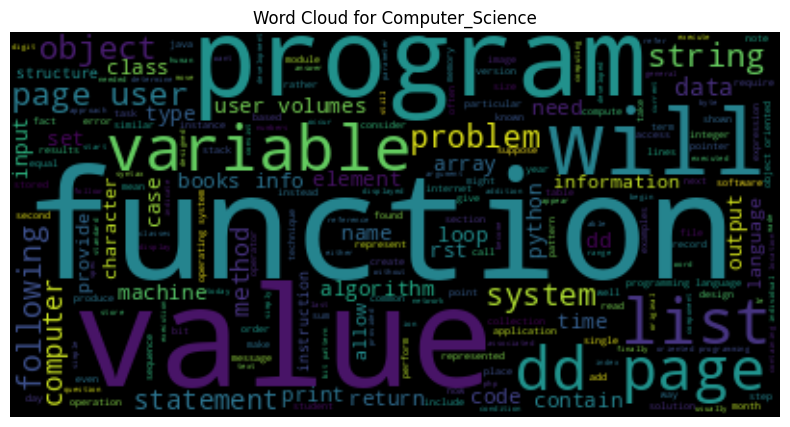

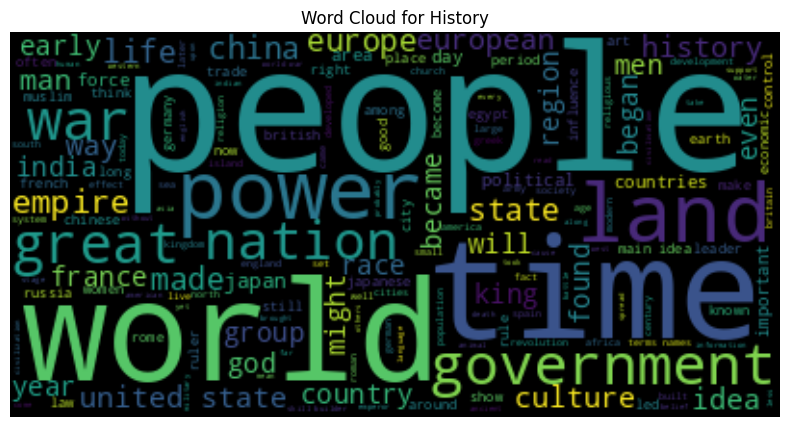

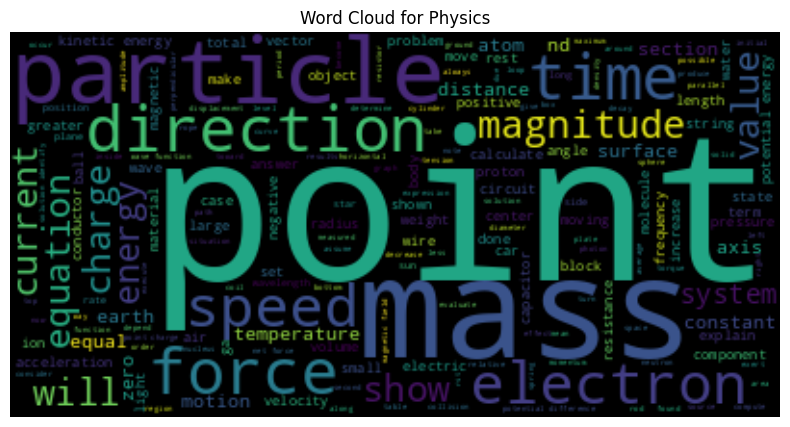

In [ ]:
# Create a word cloud for each category
create_word_cloud(data_biology, 'Biology')
create_word_cloud(data_computer_science, 'Computer_Science')
create_word_cloud(data_history, 'History')
create_word_cloud(data_physics, 'Physics')

Text(0.5, 9.444444444444438, 'The number of words')

<Figure size 800x1000 with 0 Axes>

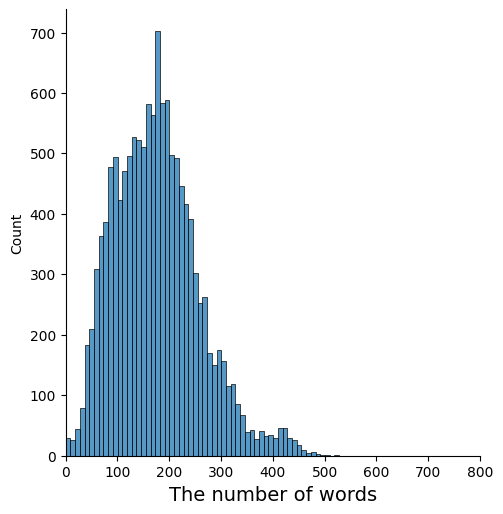

In [ ]:
# Counting the number of words in each sentence of the proccessed data
count_sent_word = [len(sentence.split()) for sentence in preprocessed_data]

# Visualize it
plt.figure(figsize=(8, 10))

sns.displot(count_sent_word)

plt.xlim(0, 800)

plt.xlabel("The number of words", fontsize=14)


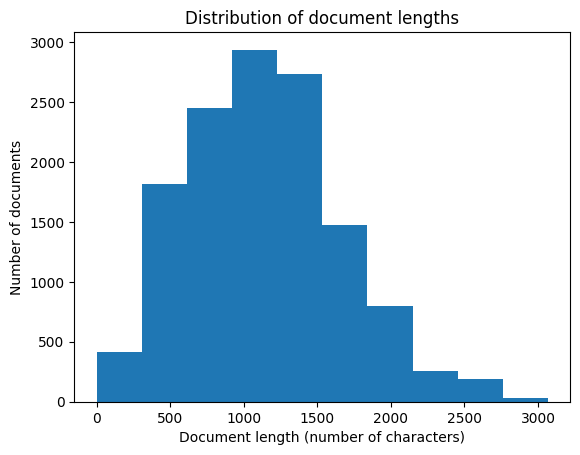

In [ ]:
# Compute the length of each text document
document_lengths = [len(doc) for doc in preprocessed_data]

# Plot a histogram of document lengths
plt.hist(document_lengths)
plt.xlabel("Document length (number of characters)")
plt.ylabel("Number of documents")
plt.title("Distribution of document lengths")
plt.show()

In [ ]:
# print the unique categories

topic_count = pd.Series(category).value_counts()

topic_categories = topic_count.index.tolist()

print(topic_categories)


['Physics', 'Computer_Science', 'Biology', 'History']


In [ ]:
# Number of categories

num_class = len(set(category))

print("Number of Categories:", num_class)

Number of Categories: 4


In [ ]:
topic_count = pd.Series(category).value_counts()
topic_count

Physics             3436
Computer_Science    3288
Biology             3234
History             3152
dtype: int64

<Axes: >

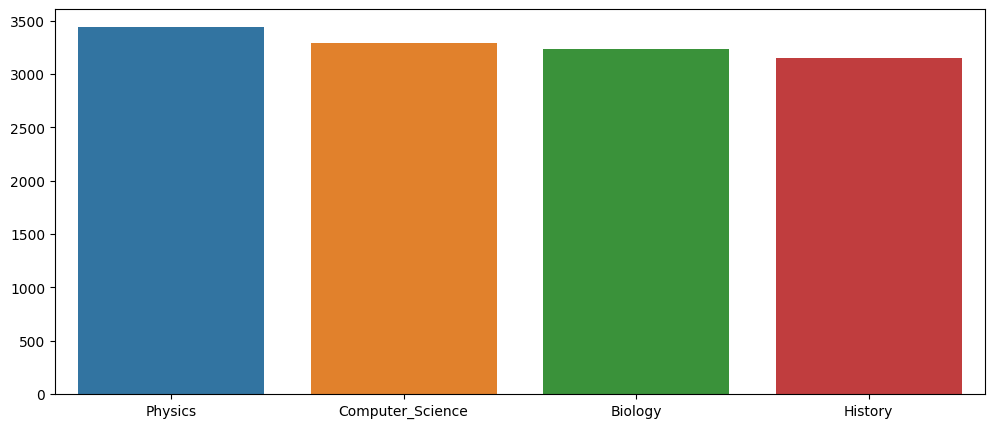

In [ ]:
# Visualize the count of each category

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(111)

sns.barplot(x=topic_categories, y=topic_count)


In [ ]:
# Remove stop words from each sentence
filtered_text_data = []
for sentence in preprocessed_data:
    filtered_sentence = " ".join([word for word in sentence.split() if word.lower() not in stop_words])
    filtered_text_data.append(filtered_sentence)

In [ ]:
filtered_text_data

['acceptable individual ignore possibility truncation errors consequences developing applications ethical develop software digits pre sent year represent year ignoring fact software flawed turn century approached ethical today digits represent year four digits argue encoding information often dilutes otherwise distorts information since essentially forces information quantified argue questionnaire subjects required record opinions responding scale five inherently flawed extent information quantifiable pros cons locations waste disposal plant quantified debate nuclear power nuclear waste quantifiable dangerous base decisions averages statistical analysis ethical news agencies report polling results without including exact wording questions possible quantify value human life accept able company stop investing improvement product even',
 'comparator functions name comparator function wish recall function names php case insensitive though still best practice match naming several examples u

In [ ]:
# Encoding the categories
encoder = LabelEncoder()
category_encode = encoder.fit_transform(category)
num_classes = len(encoder.classes_)



# Print the mapping of categories to their encoded values
print('Category encoding mapping:')
for category, code in zip(encoder.classes_, encoder.transform(encoder.classes_)):
    print(f'{category}: {code}')

Category encoding mapping:
Biology: 0
Computer_Science: 1
History: 2
Physics: 3


In [ ]:
# Split the data into 80% train and 20% combined test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(filtered_text_data, category_encode, test_size=0.3, random_state=42)

# Split the remaining 20% into 10% test and 10% validation sets(X_temp and y_temp are the temporary filtered_text_data and labels shared from the training data)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)


In [ ]:
y_val[:3]

array([2, 3, 3])

In [ ]:
X_val[:3]

['centuries beneficial technique dangerous jenner discovered inoculation germs cattle ease cowpox gave permanent pro tec tion smallpox humans cowpox milder disease risks inoculation lower jenner cowpox produce world vaccination discoveries chemistry robert boyle pio nee red scientific method chemistry considered founder modern chemistry book sceptical chymist boyle challenged aristotle idea physical world consisted four elements earth air fire water instead boyle proposed matter made smaller primary particles joined together ways boyle famous contribution chemistry boyle law law explains volume temperature pressure gas affect notions reason order spurred breakthroughs sci en soon moved fields life philosophers scholars across europe began rethink long held beliefs human condition notably rights liberties ordinary citizens thinkers helped usher move ment challenged age old relationship government pe ple eventually changed forever political landscape numerous societies vocabulary inocula

In [ ]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

9177 9177
1298 1298
2635 2635


In [ ]:
# View the first three training categories
y_train[:3]

array([0, 2, 2])

In [ ]:
# Coverting the training, testing and validation set to numpy array

X_train_nnlm = np.array(X_train)
X_val_nnlm = np.array(X_val)
X_test_nnlm = np.array(X_test)

In [ ]:
# using _1 for model 1 which is nnlm-en-dim128-with-normalization

# Creating the embedding matrix using nnlm-en-dim128-with-normalization

embedding_dim = 128
embedding_layer_1 = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
    input_shape=[],
    dtype=tf.string,
    trainable=True,
)


In [ ]:
# Define the model architecture

model_1 = tf.keras.Sequential([
    embedding_layer_1,
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 124,646,948
Trainable params: 124,646,948
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learning_rate = 0.001

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model_1.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


In [ ]:
#define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history_1 = model_1.fit(
    X_train_nnlm, y_train,
    validation_data=(X_val_nnlm, y_val),
    epochs=10, batch_size=512, verbose=1, callbacks=[early_stop]
)

# converting the X_test_nnlm and y_test(which is still the same) to X_test and y_test to work with the code for evaluation, prediction and performance matrics
X_test = X_test_nnlm
y_test = y_test

Epoch 1/10
18/18 [==============================] - 8s 290ms/step - loss: 1.2043 - accuracy: 0.5392 - val_loss: 0.7960 - val_accuracy: 0.9592
Epoch 2/10
18/18 [==============================] - 4s 243ms/step - loss: 0.6394 - accuracy: 0.8727 - val_loss: 0.3392 - val_accuracy: 0.9792
Epoch 3/10
18/18 [==============================] - 8s 431ms/step - loss: 0.3507 - accuracy: 0.9306 - val_loss: 0.1778 - val_accuracy: 0.9861
Epoch 4/10
18/18 [==============================] - 4s 236ms/step - loss: 0.2219 - accuracy: 0.9656 - val_loss: 0.1259 - val_accuracy: 0.9915
Epoch 5/10
18/18 [==============================] - 5s 301ms/step - loss: 0.1684 - accuracy: 0.9799 - val_loss: 0.1049 - val_accuracy: 0.9923
Epoch 6/10
18/18 [==============================] - 5s 258ms/step - loss: 0.1382 - accuracy: 0.9855 - val_loss: 0.0945 - val_accuracy: 0.9931
Epoch 7/10
18/18 [==============================] - 4s 219ms/step - loss: 0.1145 - accuracy: 0.9925 - val_loss: 0.0875 - val_accuracy: 0.9931
Epoch 

In [ ]:
# Evaluate the model with the test data

results_1 = model_1.evaluate(X_test, y_test)

print(results_1)

83/83 [==============================] - 1s 7ms/step - loss: 0.0826 - accuracy: 0.9901
[0.0825883224606514, 0.9901328086853027]


In [ ]:
#Predicting with the test data

results_pred_1 = model_1.predict(X_test)

83/83 [==============================] - 1s 7ms/step


In [ ]:
history_dict_1 = history_1.history
history_dict_1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

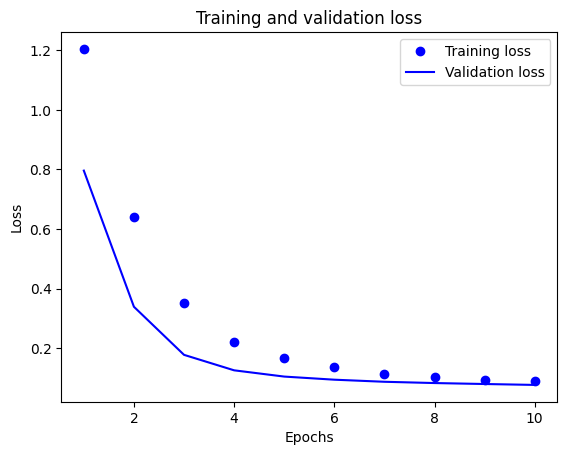

In [ ]:
# Assignig values to the history dictionary to the metrics variable
acc_1 = history_dict_1['accuracy']
val_acc_1 = history_dict_1['val_accuracy']
loss_1 = history_dict_1['loss']
val_loss_1 = history_dict_1['val_loss']

epochs_1 = range(1, len(acc_1) + 1)

# Ploting the graph for training and validation loss vs epochs
# "bo" is for "blue dot"
plt.plot(epochs_1, loss_1, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_1, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

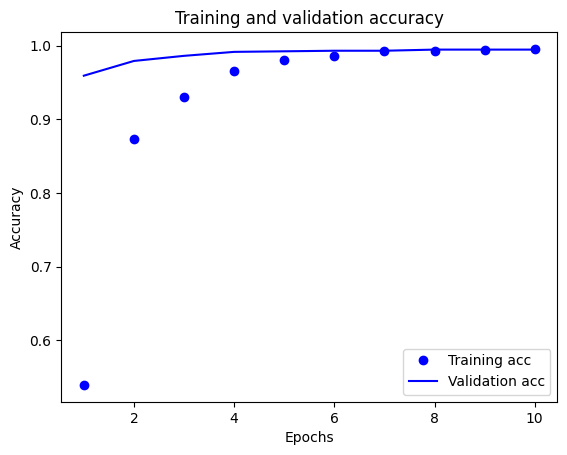

In [ ]:
# Ploting the graph for training and validation accuracy vs epochs

plt.clf()

plt.plot(epochs_1, acc_1, 'bo', label='Training acc')
plt.plot(epochs_1, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Convert to 1D numpy array
y_pred_1 = np.argmax(results_pred_1, axis=1)

# Assign y_test value to y_true
y_true_1 = y_test

# Confusion Matrix
cm_1 = confusion_matrix(y_true_1, y_pred_1)
print("Confusion Matrix:\n", cm_1, "\n")

# Accuracy
accuracy_1 = accuracy_score(y_true_1, y_pred_1)
print("Accuracy:", accuracy_1, "\n")

# ROC-AUC Score (One-vs-Rest approach)

y_true_binarized = label_binarize(y_true_1, classes=[0, 1, 2, 3])
y_pred_binarized = label_binarize(y_pred_1, classes=[0, 1, 2, 3])
roc_auc_1 = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr')
print("ROC-AUC Score:", roc_auc_1, "\n")

# Precision
precision_1 = precision_score(y_true_1, y_pred_1, average='weighted')
print("Precision:", precision_1, "\n")

# Recall
recall_1 = recall_score(y_true_1, y_pred_1, average='weighted')
print("Recall:", recall_1, "\n")

# F1 Score
f1_1 = f1_score(y_true_1, y_pred_1, average='weighted')
print("F1 Score:", f1_1, "\n")

# Cohen's Kappa
kappa_1 = cohen_kappa_score(y_true_1, y_pred_1)
print("Cohen's Kappa:", kappa_1, "\n")

# Matthews Correlation Coefficient (MCC)
mcc_1 = matthews_corrcoef(y_true_1, y_pred_1)
print("Matthews Correlation Coefficient (MCC):", mcc_1, "\n")

# Classification Report
report_1 = classification_report(y_true_1, y_pred_1)
print("Classification Report:\n", report_1)


Confusion Matrix:
 [[638   1   5   3]
 [  1 669   1   1]
 [  6   0 616   3]
 [  4   1   0 686]] 

Accuracy: 0.9901328273244782 

ROC-AUC Score: 0.9933564404020134 

Precision: 0.9901412450825817 

Recall: 0.9901328273244782 

F1 Score: 0.9901344204216211 

Cohen's Kappa: 0.9868371427358262 

Matthews Correlation Coefficient (MCC): 0.9868388494988445 

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       647
           1       1.00      1.00      1.00       672
           2       0.99      0.99      0.99       625
           3       0.99      0.99      0.99       691

    accuracy                           0.99      2635
   macro avg       0.99      0.99      0.99      2635
weighted avg       0.99      0.99      0.99      2635



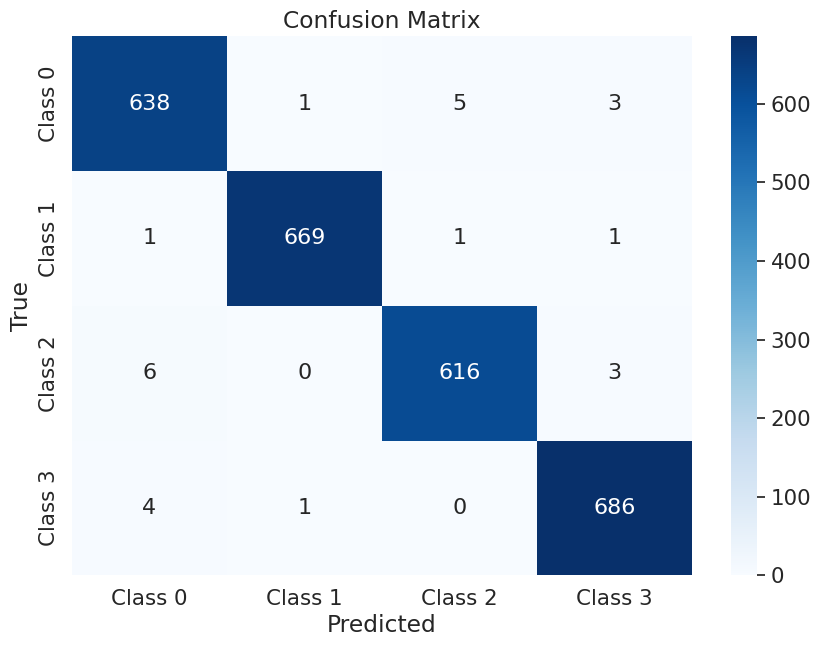

In [ ]:
# Calculate the confusion matrix
cm_1 = confusion_matrix(y_true_1, y_pred_1)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_1, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


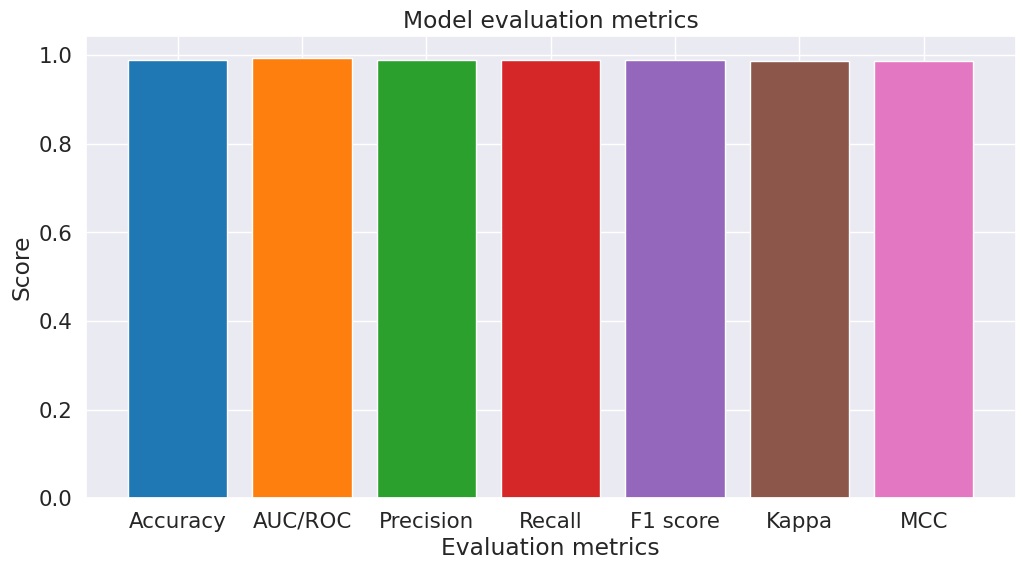

In [ ]:
# Evaluation metrics scores
metrics = ['Accuracy', 'AUC/ROC', 'Precision', 'Recall', 'F1 score', 'Kappa', 'MCC']
scores_1 = [accuracy_1, roc_auc_1, precision_1, recall_1, f1_1, kappa_1, mcc_1]

# Set the desired figure size (width, height)
plt.figure(figsize=(12, 6))

# Create a bar plot
plt.bar(metrics, scores_1, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])

# Add labels and title
plt.xlabel('Evaluation metrics')
plt.ylabel('Score')
plt.title('Model evaluation metrics')

# Show plot
plt.show()


In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert integer-encoded labels to one-hot vectors
y_train_use = to_categorical(y_train)
y_val_use = to_categorical(y_val)
y_test_use = to_categorical(y_test)


# Coverting the training, testing and validation set to numpy array

X_train_use = np.array(X_train)
X_val_use = np.array(X_val)
X_test_use = np.array(X_test)

# Load the Universal Sentence Encoder
use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)



In [ ]:
# Define the model architecture

# Define the model
model_2 = Sequential()
model_2.add(use)
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(len(encoder.classes_), activation='softmax'))


# Provide an example batch to build the model
example_inputs = tf.constant(["series forms parallel comb tion keep mind total potential difference across resistors connected series sum individual potential differ en ces potential difference across resistors connected parallel every resistor equals potential difference across combination current resistors connected series every resistor equals current combination total current resistors connected parallel sum currents individual resistors evaluate answer check whether results cons tent equivalent resistance resistors connected series greater individual resistor res tors parallel less individual resistor equivalent resistance equivalent resistance network current resistor source emf negligible internal resistance solution identify set network resistors combination series parallel resistances determine steps reducing combination resistors single equivalent resistor ding current resistor continued"], dtype=tf.string)
model_2(example_inputs)

# print the model summary.
model_2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 256,930,180
Trainable params: 132,356
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
learning_rate = 0.001

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
#define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history_2 = model_2.fit(
    X_train_use, y_train_use,
    validation_data=(X_val_use, y_val_use),
    epochs=10, batch_size=512, verbose=1, callbacks=[early_stop]
)

Epoch 1/10
18/18 [==============================] - 7s 247ms/step - loss: 1.0961 - accuracy: 0.8493 - val_loss: 0.7250 - val_accuracy: 0.9545
Epoch 2/10
18/18 [==============================] - 5s 296ms/step - loss: 0.4804 - accuracy: 0.9603 - val_loss: 0.2783 - val_accuracy: 0.9653
Epoch 3/10
18/18 [==============================] - 4s 219ms/step - loss: 0.2079 - accuracy: 0.9674 - val_loss: 0.1520 - val_accuracy: 0.9676
Epoch 4/10
18/18 [==============================] - 3s 195ms/step - loss: 0.1304 - accuracy: 0.9721 - val_loss: 0.1133 - val_accuracy: 0.9723
Epoch 5/10
18/18 [==============================] - 5s 279ms/step - loss: 0.1015 - accuracy: 0.9749 - val_loss: 0.0966 - val_accuracy: 0.9738
Epoch 6/10
18/18 [==============================] - 4s 212ms/step - loss: 0.0857 - accuracy: 0.9778 - val_loss: 0.0853 - val_accuracy: 0.9746
Epoch 7/10
18/18 [==============================] - 4s 208ms/step - loss: 0.0751 - accuracy: 0.9796 - val_loss: 0.0790 - val_accuracy: 0.9753
Epoch 

In [ ]:
# Evaluate the model with the test data

results_2 = model_2.evaluate(X_test_use, y_test_use)

print(results_2)

83/83 [==============================] - 3s 35ms/step - loss: 0.0727 - accuracy: 0.9780
[0.07273001968860626, 0.977988600730896]


In [ ]:
#Predicting with the test data

results_pred_2 = model_2.predict(X_test_use)

83/83 [==============================] - 2s 20ms/step


In [ ]:
history_dict_2 = history_2.history
history_dict_2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

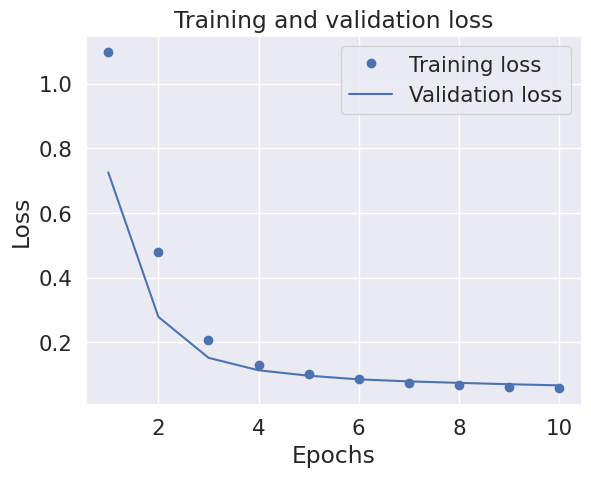

In [ ]:
# Assignig values to the history dictionary to the metrics variable
acc_2 = history_dict_2['accuracy']
val_acc_2 = history_dict_2['val_accuracy']
loss_2 = history_dict_2['loss']
val_loss_2 = history_dict_2['val_loss']

epochs_2 = range(1, len(acc_2) + 1)

# Ploting the graph for training and validation loss vs epochs
# "bo" is for "blue dot"
plt.plot(epochs_2, loss_2, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_2, val_loss_2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

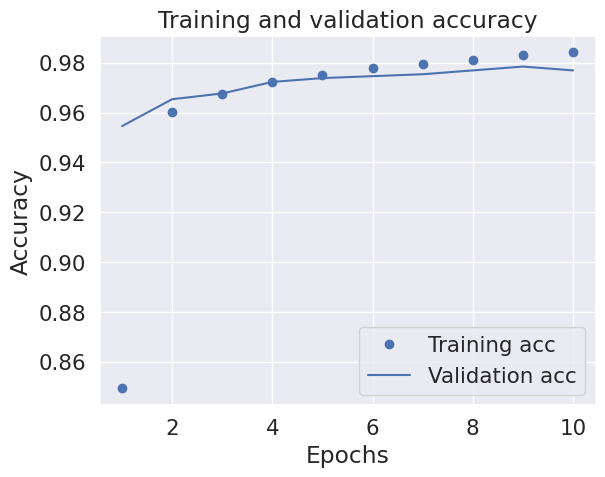

In [ ]:
# Ploting the graph for training and validation accuracy vs epochs

plt.clf()

plt.plot(epochs_2, acc_2, 'bo', label='Training acc')
plt.plot(epochs_2, val_acc_2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Convert to 1D numpy array
y_pred_2 = np.argmax(results_pred_2, axis=1)

# Assign y_test value to y_true
y_true_2 = y_test

# Confusion Matrix
cm_2 = confusion_matrix(y_true_2, y_pred_2)
print("Confusion Matrix:\n", cm_2, "\n")

# Accuracy
accuracy_2 = accuracy_score(y_true_2, y_pred_2)
print("Accuracy:", accuracy_2, "\n")

# ROC-AUC Score (One-vs-Rest approach)

y_true_binarized = label_binarize(y_true_2, classes=[0, 1, 2, 3])
y_pred_binarized = label_binarize(y_pred_2, classes=[0, 1, 2, 3])
roc_auc_2 = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr')
print("ROC-AUC Score:", roc_auc_2, "\n")

# Precision
precision_2 = precision_score(y_true_2, y_pred_2, average='weighted')
print("Precision:", precision_2, "\n")

# Recall
recall_2 = recall_score(y_true_2, y_pred_2, average='weighted')
print("Recall:", recall_2, "\n")

# F1 Score
f1_2 = f1_score(y_true_2, y_pred_2, average='weighted')
print("F1 Score:", f1_2, "\n")

# Cohen's Kappa
kappa_2 = cohen_kappa_score(y_true_2, y_pred_2)
print("Cohen's Kappa:", kappa_2, "\n")

# Matthews Correlation Coefficient (MCC)
mcc_2 = matthews_corrcoef(y_true_2, y_pred_2)
print("Matthews Correlation Coefficient (MCC):", mcc_2, "\n")

# Classification Report
report_2 = classification_report(y_true_2, y_pred_2)
print("Classification Report:\n", report_2)


Confusion Matrix:
 [[630   1  10   6]
 [  3 660   1   8]
 [ 13   3 607   2]
 [  6   1   4 680]] 

Accuracy: 0.977988614800759 

ROC-AUC Score: 0.9852302654758208 

Precision: 0.978048833145863 

Recall: 0.977988614800759 

F1 Score: 0.9780036151940372 

Cohen's Kappa: 0.970636804574226 

Matthews Correlation Coefficient (MCC): 0.9706468755315805 

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       647
           1       0.99      0.98      0.99       672
           2       0.98      0.97      0.97       625
           3       0.98      0.98      0.98       691

    accuracy                           0.98      2635
   macro avg       0.98      0.98      0.98      2635
weighted avg       0.98      0.98      0.98      2635



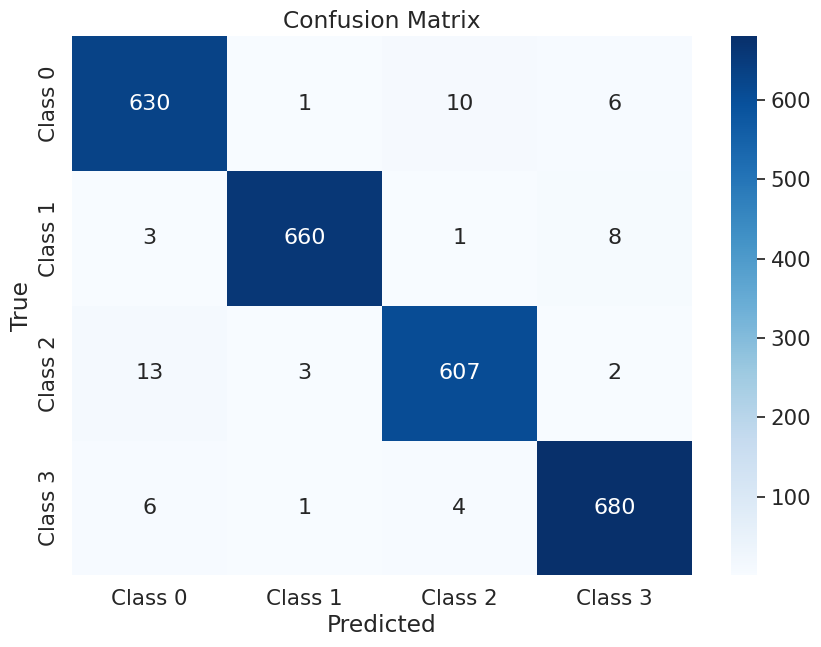

In [ ]:
# Calculate the confusion matrix
cm_2 = confusion_matrix(y_true_2, y_pred_2)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_2, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


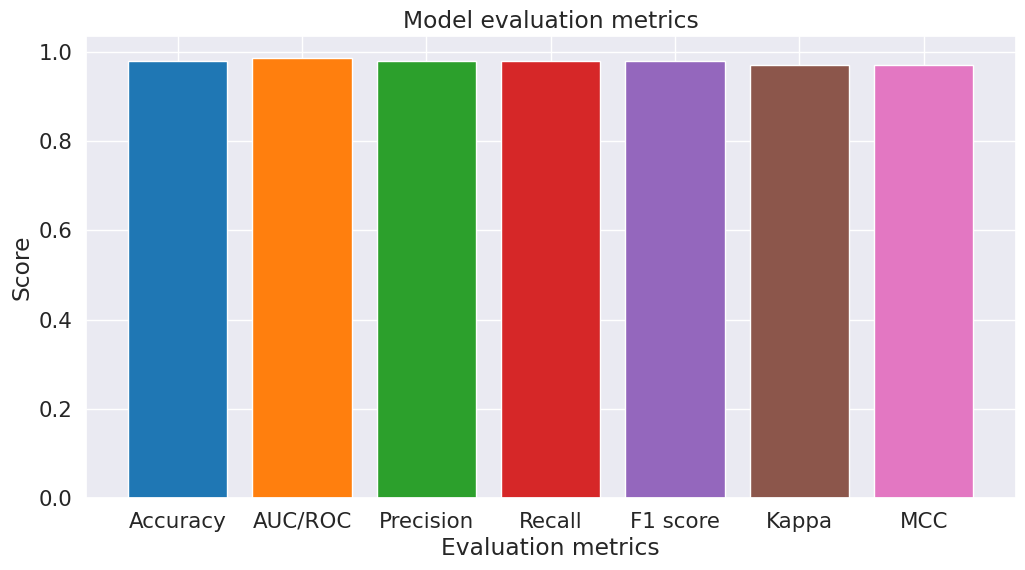

In [ ]:
# Evaluation metrics scores
metrics = ['Accuracy', 'AUC/ROC', 'Precision', 'Recall', 'F1 score', 'Kappa', 'MCC']
scores = [accuracy_2, roc_auc_2, precision_2, recall_2, f1_2, kappa_2, mcc_2]

# Set the desired figure size (width, height)
plt.figure(figsize=(12, 6))

# Create a bar plot
plt.bar(metrics, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])

# Add labels and title
plt.xlabel('Evaluation metrics')
plt.ylabel('Score')
plt.title('Model evaluation metrics')

# Show plot
plt.show()


In [ ]:

# loading the bert model from tensorflow hub

import tensorflow_hub as hub

bert_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
bert_layer = hub.KerasLayer(bert_model_url, trainable=False)

# tokenize the preprocessed text
import bert
from bert import tokenization
from bert.tokenization import bert_tokenization


vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def tokenize_and_preprocess(text):
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    return input_ids

def prepare_bert_input(text, max_seq_length):
    input_ids = tokenize_and_preprocess(text)

    # Truncate the input sequence if it's longer than the max_seq_length
    if len(input_ids) > max_seq_length:
        input_ids = input_ids[:max_seq_length]

    # Pad the input sequence if it's shorter than the max_seq_length
    elif len(input_ids) < max_seq_length:
        pad_length = max_seq_length - len(input_ids)
        input_ids += [0] * pad_length

    # Create input_mask and segment_ids arrays
    input_mask = [1 if token_id != 0 else 0 for token_id in input_ids]
    segment_ids = [0] * max_seq_length

    return input_ids, input_mask, segment_ids

# define a function to get the input_id, input_mask and segment_id

def process_dataset(texts, max_seq_length=128):
    input_ids_list, input_mask_list, segment_ids_list = [], [], []

    for text in texts:
        input_ids, input_mask, segment_ids = prepare_bert_input(text, max_seq_length)
        input_ids_list.append(input_ids)
        input_mask_list.append(input_mask)
        segment_ids_list.append(segment_ids)

    return (
        tf.constant(input_ids_list, dtype=tf.int32),
        tf.constant(input_mask_list, dtype=tf.int32),
        tf.constant(segment_ids_list, dtype=tf.int32),
    )

train_input_ids, train_input_mask, train_segment_ids = process_dataset(X_train)
test_input_ids, test_input_mask, test_segment_ids = process_dataset(X_test)
val_input_ids, val_input_mask, val_segment_ids = process_dataset(X_val)

# There was an OOM error when trying to use the get_bert_embeddings_for_dataset function so processing data in smaller batches

# define a function to extract from the entire dataset

def get_bert_embeddings_for_dataset(input_ids, input_mask, segment_ids, batch_size=32):
    num_examples = input_ids.shape[0]
    embeddings_list = []

    for start_idx in range(0, num_examples, batch_size):
        end_idx = min(start_idx + batch_size, num_examples)
        inputs = {
            'input_word_ids': input_ids[start_idx:end_idx],
            'input_mask': input_mask[start_idx:end_idx],
            'input_type_ids': segment_ids[start_idx:end_idx]
        }
        batch_embeddings = bert_layer(inputs)['pooled_output']
        embeddings_list.append(batch_embeddings)

    embeddings = tf.concat(embeddings_list, axis=0)
    return embeddings

# Extract the embedding from the training, testing and validation set

train_embeddings = get_bert_embeddings_for_dataset(train_input_ids, train_input_mask, train_segment_ids)
test_embeddings = get_bert_embeddings_for_dataset(test_input_ids, test_input_mask, test_segment_ids)
val_embeddings = get_bert_embeddings_for_dataset(val_input_ids, val_input_mask, val_segment_ids)

# convert the encoded category that has been splitted in to training, testing and validation to TensorFlow tensors

train_labels_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
test_labels_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)
val_labels_tensor = tf.convert_to_tensor(y_val, dtype=tf.int32)

# Now we create and train the model based on the bert embedding method

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

input_layer = Input(shape=(train_embeddings.shape[1],))
hidden_layer = Dense(128, activation='relu')(input_layer)
output_layer = Dense(len(encoder.classes_), activation='softmax')(hidden_layer)



In [ ]:
model_3 = Model(inputs=input_layer, outputs=output_layer)

learning_rate = 0.001
# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model_3.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])


#define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history_3 = model_3.fit(train_embeddings, train_labels_tensor,
                    validation_data=(val_embeddings, val_labels_tensor),
                    epochs=10, batch_size=32, verbose=1, callbacks=[early_stop])


# converting the test_embeddings and test_labels_tensor to X_test and y_test to work with the code we use for the three NNLM embedding methods
X_test_bert = test_embeddings
y_test_bert = test_labels_tensor


Epoch 1/10
287/287 [==============================] - 2s 4ms/step - loss: 0.5974 - accuracy: 0.7857 - val_loss: 0.3486 - val_accuracy: 0.8921
Epoch 2/10
287/287 [==============================] - 2s 6ms/step - loss: 0.2976 - accuracy: 0.9036 - val_loss: 0.2559 - val_accuracy: 0.9106
Epoch 3/10
287/287 [==============================] - 1s 5ms/step - loss: 0.2337 - accuracy: 0.9214 - val_loss: 0.2303 - val_accuracy: 0.9276
Epoch 4/10
287/287 [==============================] - 1s 4ms/step - loss: 0.2024 - accuracy: 0.9311 - val_loss: 0.1753 - val_accuracy: 0.9414
Epoch 5/10
287/287 [==============================] - 1s 4ms/step - loss: 0.1967 - accuracy: 0.9351 - val_loss: 0.1938 - val_accuracy: 0.9291
Epoch 6/10
287/287 [==============================] - 1s 3ms/step - loss: 0.1792 - accuracy: 0.9410 - val_loss: 0.1965 - val_accuracy: 0.9337


In [ ]:
# Evaluate the model with the test data

results_3 = model_3.evaluate(X_test_bert, y_test_bert)

print(results_3)

83/83 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.9336
[0.19211463630199432, 0.9335863590240479]


In [ ]:
#Predicting with the test data

results_pred_3 = model_3.predict(X_test_bert)

83/83 [==============================] - 0s 2ms/step


In [ ]:
history_dict_3 = history_3.history
history_dict_3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

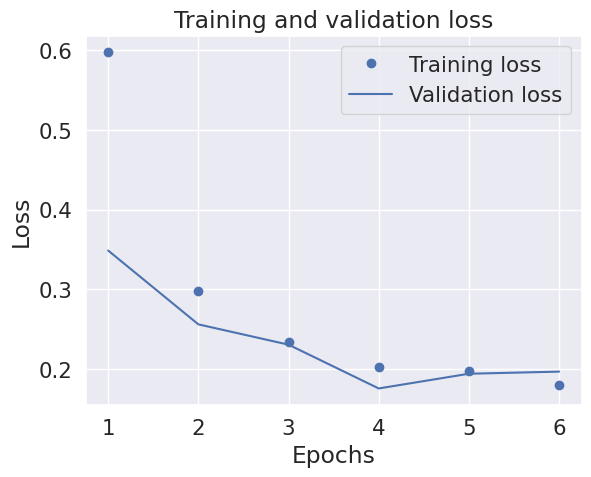

In [ ]:
# Assignig values to the history dictionary to the metrics variable
acc_3 = history_dict_3['accuracy']
val_acc_3 = history_dict_3['val_accuracy']
loss_3 = history_dict_3['loss']
val_loss_3 = history_dict_3['val_loss']

epochs_3 = range(1, len(acc_3) + 1)

# Ploting the graph for training and validation loss vs epochs
# "bo" is for "blue dot"
plt.plot(epochs_3, loss_3, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_3, val_loss_3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

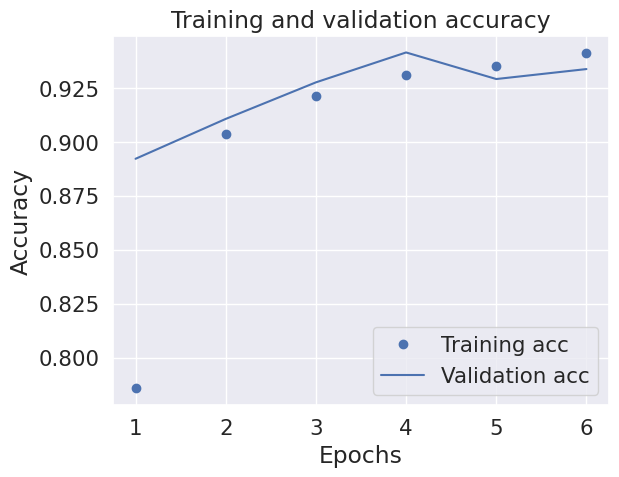

In [ ]:
# Ploting the graph for training and validation accuracy vs epochs

plt.clf()

plt.plot(epochs_3, acc_3, 'bo', label='Training acc')
plt.plot(epochs_3, val_acc_3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Convert to 1D numpy array
y_pred_3 = np.argmax(results_pred_3, axis=1)

# Assign y_test value to y_true
y_true_3 = y_test_bert

# Confusion Matrix
cm_3 = confusion_matrix(y_true_3, y_pred_3)
print("Confusion Matrix:\n", cm_3, "\n")

# Accuracy
accuracy_3 = accuracy_score(y_true_3, y_pred_3)
print("Accuracy:", accuracy_3, "\n")

# ROC-AUC Score (One-vs-Rest approach)

y_true_binarized = label_binarize(y_true_3, classes=[0, 1, 2, 3])
y_pred_binarized = label_binarize(y_pred_3, classes=[0, 1, 2, 3])
roc_auc_3 = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr')
print("ROC-AUC Score:", roc_auc_3, "\n")

# Precision
precision_3 = precision_score(y_true_3, y_pred_3, average='weighted')
print("Precision:", precision_3, "\n")

# Recall
recall_3 = recall_score(y_true_3, y_pred_3, average='weighted')
print("Recall:", recall_3, "\n")

# F1 Score
f1_3 = f1_score(y_true_3, y_pred_3, average='weighted')
print("F1 Score:", f1_3, "\n")

# Cohen's Kappa
kappa_3 = cohen_kappa_score(y_true_3, y_pred_3)
print("Cohen's Kappa:", kappa_3, "\n")

# Matthews Correlation Coefficient (MCC)
mcc_3 = matthews_corrcoef(y_true_3, y_pred_3)
print("Matthews Correlation Coefficient (MCC):", mcc_3, "\n")

# Classification Report
report_3 = classification_report(y_true_3, y_pred_3)
print("Classification Report:\n", report_3)


Confusion Matrix:
 [[553   4  78  12]
 [  4 642  15  11]
 [  7   5 606   7]
 [  8   8  16 659]] 

Accuracy: 0.9335863377609108 

ROC-AUC Score: 0.9556853748962596 

Precision: 0.9376875072673694 

Recall: 0.9335863377609108 

F1 Score: 0.933794247911414 

Cohen's Kappa: 0.9114467540782503 

Matthews Correlation Coefficient (MCC): 0.912665026034535 

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91       647
           1       0.97      0.96      0.96       672
           2       0.85      0.97      0.90       625
           3       0.96      0.95      0.96       691

    accuracy                           0.93      2635
   macro avg       0.94      0.93      0.93      2635
weighted avg       0.94      0.93      0.93      2635



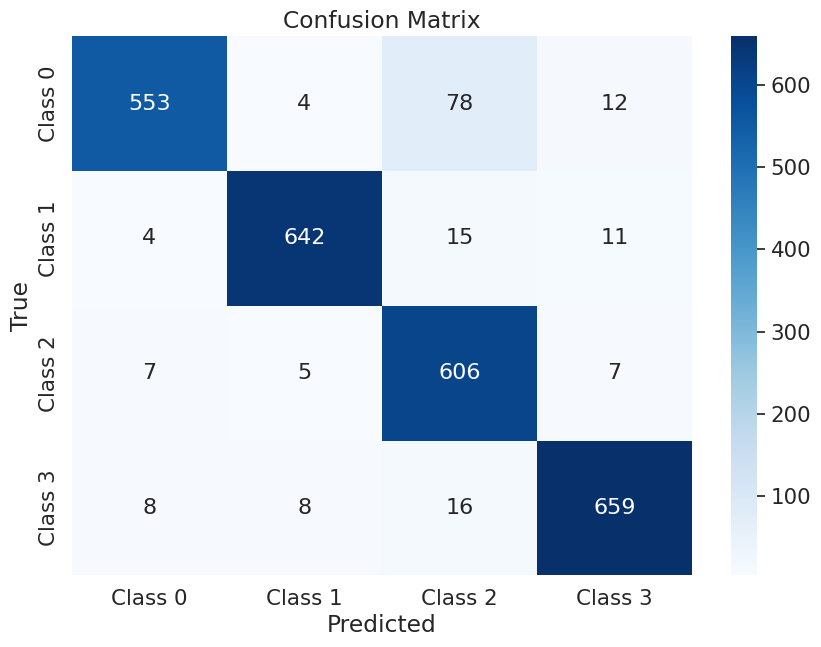

In [ ]:
# Calculate the confusion matrix
cm_3= confusion_matrix(y_true_3, y_pred_3)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_3, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


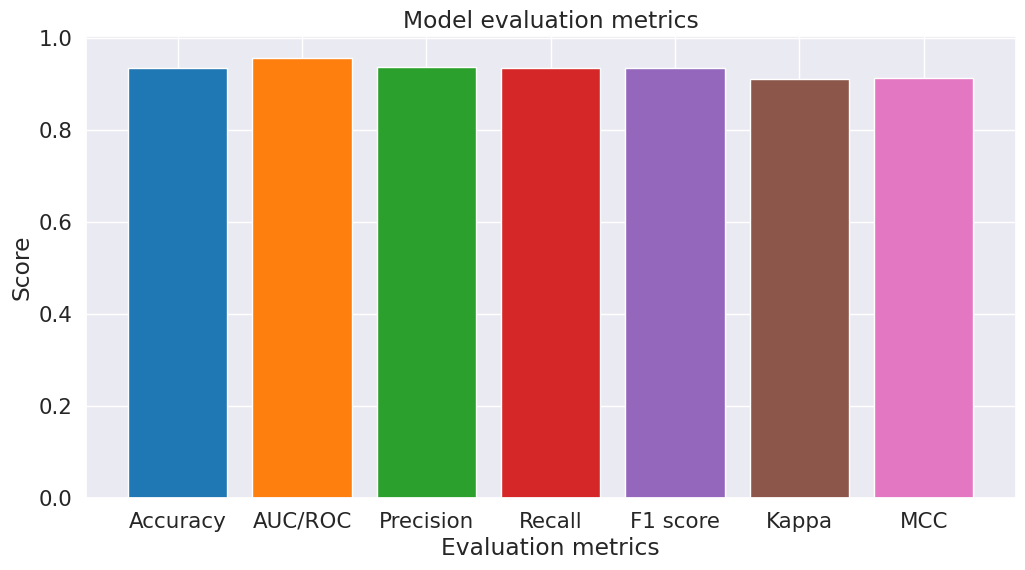

In [ ]:
# Evaluation metrics scores
metrics = ['Accuracy', 'AUC/ROC', 'Precision', 'Recall', 'F1 score', 'Kappa', 'MCC']
scores_3 = [accuracy_3, roc_auc_3, precision_3, recall_3, f1_3, kappa_3, mcc_3]

# Set the desired figure size (width, height)
plt.figure(figsize=(12, 6))

# Create a bar plot
plt.bar(metrics, scores_3, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])

# Add labels and title
plt.xlabel('Evaluation metrics')
plt.ylabel('Score')
plt.title('Model evaluation metrics')

# Show plot
plt.show()


In [ ]:
# Find the best model based on their accuracy
best_model = ''
if results_1[1] >= results_3[1] and results_1[1] >= results_3[1]:
    best_model = 'NNLM-128'
elif results_2[1] >= results_1[1] and results_2[1] >= results_3[1]:
    best_model = 'USE'
else:
    best_model = 'BERT'

# Print the best model
print(f'{best_model} is the best model.')



NNLM-128 is the best model.


In [ ]:
# Testing the Best model on unseen data

if best_model == 'NNLM-128':
    user_input = input("Enter your text: ")
    preprocessed_input = preprocess_text(user_input)
    input_array = np.array([preprocessed_input])
    predictions = model_1.predict(input_array)
    predicted_label = np.argmax(predictions, axis=-1)
    predicted_class_name = encoder.inverse_transform(predicted_label)[0]
    print(f"The input text belongs to the category: {predicted_class_name}")
    print("Predicted with NNLM-128 Model")


elif best_model == 'USE':
    user_input_2 = input("Enter your text: ")
    preprocessed_input_2 = preprocess_text(user_input_2)
    input_array_2 = np.array([preprocessed_input_2])
    predictions_2 = model_2.predict(input_array_2)
    predicted_label_2 = np.argmax(predictions_2, axis=-1)
    predicted_class_name_2 = encoder.inverse_transform(predicted_label_2)[0]
    print(f"The input text belongs to the category: {predicted_class_name_2}")
    print("Predicted with USE Model")

else:
    user_input_3 = input("Enter your text: ")
    user_input_ids, user_input_mask, user_segment_ids = process_dataset(user_input_3)
    user_input_embeddings = get_bert_embeddings_for_dataset(user_input_ids, user_input_mask, user_segment_ids)
    predictions_3 = model_3.predict(user_input_embeddings)
    predicted_label_3 = np.argmax(predictions_3, axis=-1)
    predicted_label_3 = predicted_label_3.reshape((1, len(predicted_label_3)))
    predicted_class_name_3 = encoder.inverse_transform(predicted_label_3)[0]
    print(f"The input text belongs to the category: {predicted_class_name_3}")
    print("Predicted with BERT Model")

Enter your text: Light is a form of energy. This is demonstrated by Crookes Radiometer or Solar Cells • Light travels in straight lines. This is demonstrated by an experiment involving a card with an hole looking at light source e.g. candle. Also the simple camera: candle black box one side pin hole other side grease proof paper. We see the candle upside down on the paper
1/1 [==============================] - 0s 37ms/step
The input text belongs to the category: Physics
Predicted with NNLM-128 Model
